In [2]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

# Setup

In [3]:
model = BabyMAKROModelClass(name='Extended') # create an instance of the model

In [4]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [5]:
model.find_ss(do_print=True)

Labor supply and search and matching:
ss.S = 7.44,  ss.L = 56.28,  ss.delta_L = 0.07,  ss.v = 16.52,  ss.m_v = 0.23
Capital agency FOC:
ss.r_K = 0.14
Production firm pricing:
ss.r_ell = 2.71
Labor agency:
ss.ell = 55.87,  ss.w = 2.68
Government:
ss.B_G = 150.00,  ss.G = 50.00,  ss.tau = 0.37
Households:
solving for household behavior: result.converged = True
ss.C = 106.55,  ss.B = 292.43
Production firm FOCs:
ss.K = 557.43
Capital accumulation equation:
ss.I = 55.74
Output in production firm:
ss.Y = 229.56
Market clearing:
ss.C_Y = 74.58,  ss.G_Y = 35.00,  ss.I_Y = 36.23,  ss.X_Y = 83.75
[ ss.C_M = 31.96,  ss.G_M = 15.00,  ss.I_M = 19.51,  ss.X_M = 55.83 ] = ss.M = 122.31
ss.X = 139.58
Bargaining:
par.phi = 0.988


**Household behavior:**

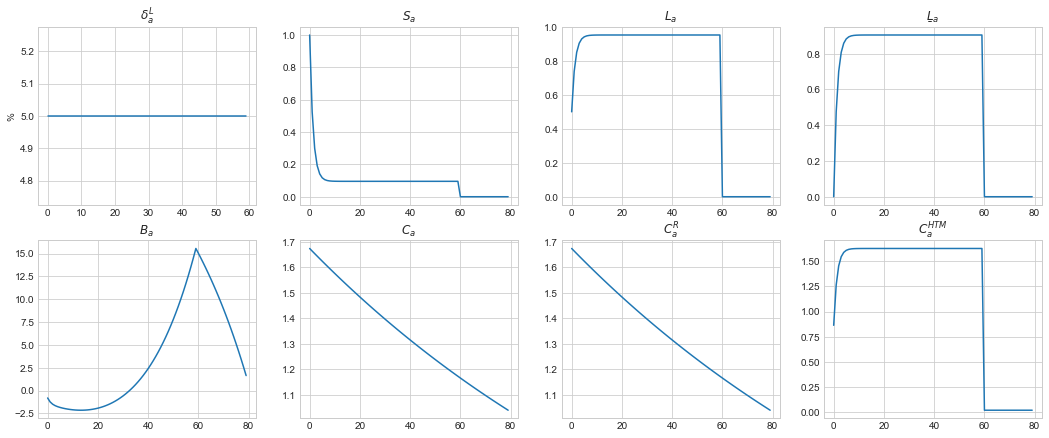

In [6]:
fig = plt.figure(figsize=(3*6,3*6/2.5))

ax = fig.add_subplot(2,4,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(2,4,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(2,4,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(2,4,4)
ax.plot(model.ss.L_ubar_a)
ax.set_title(r'$L\underbar_a$')

ax = fig.add_subplot(2,4,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$')

ax = fig.add_subplot(2,4,6)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(2,4,7)
ax.plot(model.ss.C_R)
ax.set_ylabel('')
ax.set_title('$C^R_a$')

ax = fig.add_subplot(2,4,8)
ax.plot(model.ss.C_HTM)
ax.set_ylabel('')
ax.set_title('$C^{HTM}_a$');

# Speed and error tests

In [7]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [8]:
%time model.evaluate_blocks(py=True)

CPU times: user 1.89 s, sys: 22.6 ms, total: 1.91 s
Wall time: 1.93 s


**Check errors:**

In [9]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 5.14e+01
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 0.00e+00


**First numba evaluation:**

In [10]:
%time model.evaluate_blocks()

CPU times: user 17.9 s, sys: 307 ms, total: 18.2 s
Wall time: 18.5 s


**Time:**

In [11]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

4.64 ms ± 69.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.5 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%timeit model.evaluate_blocks(py=True)

229 ms ± 8.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [13]:
model.calc_jac(do_print=True)

Jacobian calculated in 11.2 secs secs


Only needs to be calculated once.

In [19]:
model.errorssol.__dict__['bargaining_cond']

AttributeError: 'BabyMAKROModelClass' object has no attribute 'errorssol'

**Set exogenous variables:**

In [27]:
#model.sol.bargaining_cond

In [29]:
np.hstack([np.array([]),model.sol.bargaining_cond.ravel()]).shape

(500,)

model.set_exo_ss()Here we shock export demand:

In [67]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
sol.chi[:Tshock] = ss.chi + shock*persistence

Check errors when guessing at steady state -> excess demand

In [68]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 5.14e+01
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 8.37e-01


**Find IRF:**

In [69]:
model.find_IRF()

initial:
   max. abs. error = 5.14e+01
    0.00e+00 in bargaining_cond
    5.14e+01 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    8.37e-01 in mkt_clearing

it = 0
 solve: t1-t0 = 0.1 secs
   max. abs. error = 5.14e+01
    2.49e-03 in bargaining_cond
    1.99e+00 in Bq_match
    6.57e-04 in FOC_capital_agency
    3.88e-02 in FOC_K_ell
    6.53e-01 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.1 secs
   max. abs. error = 1.99e+00
    9.04e-04 in bargaining_cond
    4.58e-01 in Bq_match
    8.74e-04 in FOC_capital_agency
    1.26e-02 in FOC_K_ell
    2.36e-01 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 4.58e-01
    3.91e-04 in bargaining_cond
    8.40e-02 in Bq_match
    1.93e-04 in FOC_capital_agency
    5.80e-03 in FOC_K_ell
    1.05e-01 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

**Plot:**

Note: resultater


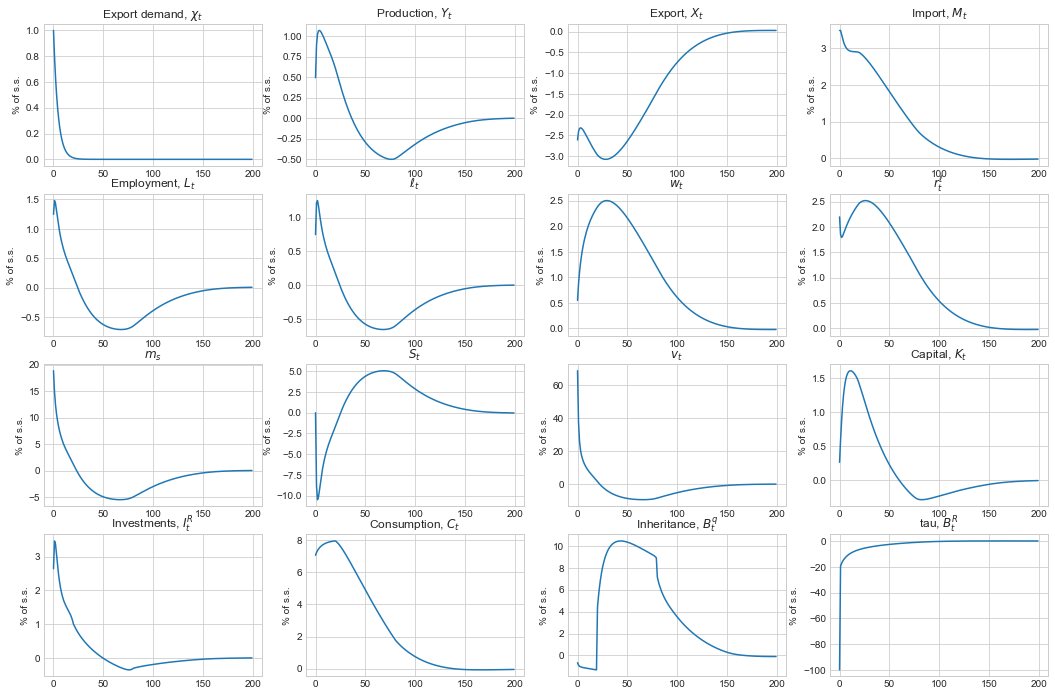

In [70]:
T_IRF = 200

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(4,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(4,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(4,4,3)
ax.plot((sol.X[:T_IRF]/(ss.X)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export, $X_t$')

ax = fig.add_subplot(4,4,4)
ax.plot((sol.M[:T_IRF]/(ss.M)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import, $M_t$')

ax = fig.add_subplot(4,4,5)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(4,4,6)
ax.plot((sol.ell[:T_IRF]/(ss.ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$\ell_t$')

ax = fig.add_subplot(4,4,7)
ax.plot((sol.w[:T_IRF]/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$w_t$')

ax = fig.add_subplot(4,4,8)
ax.plot((sol.r_ell[:T_IRF]/(ss.r_ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$r^{\ell}_t$')

ax = fig.add_subplot(4,4,9)
ax.plot((sol.m_s[:T_IRF]/(ss.m_s)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$m_s$')

ax = fig.add_subplot(4,4,10)
ax.plot((sol.S[:T_IRF]/(ss.S)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$S_t$')

ax = fig.add_subplot(4,4,11)
ax.plot((sol.v[:T_IRF]/(ss.v)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$v_t$')

ax = fig.add_subplot(4,4,12)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(4,4,13)
ax.plot((sol.I[:T_IRF]/(ss.I)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Investments, $I^R_t$')

ax = fig.add_subplot(4,4,14)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(4,4,15)
ax.plot((sol.Bq[:T_IRF]/(ss.Bq)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Inheritance, $B^q_t$')

ax = fig.add_subplot(4,4,16)
ax.plot((sol.tau[:T_IRF]/(ss.tau)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('tau, $B^R_t$');

print('Note: resultater')

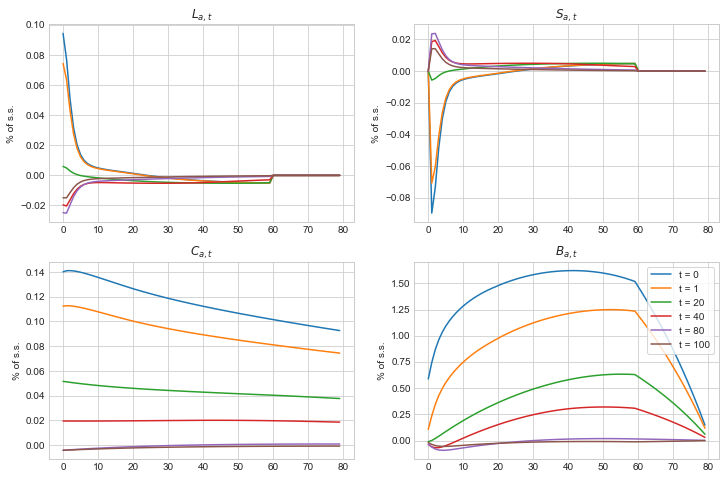

In [71]:
Periods = [0,1,20,40,80,100]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,2,1)
for t in Periods:
    L_a = np.zeros(par.A)
    for a in range(par.A):
        L_a[a] = sol.L_a[a,t+a]
    ax.plot(L_a-ss.L_a,label=f'{t = }')
ax.set_ylabel('% of s.s.')
ax.set_title('$L_{a,t}$')

ax = fig.add_subplot(2,2,2)
for t in Periods:
    S_a = np.zeros(par.A)
    for a in range(par.A):
        S_a[a] = sol.S_a[a,t+a]
    ax.plot(S_a-ss.S_a,label=f'{t = }')
ax.set_ylabel('% of s.s.')
ax.set_title('$S_{a,t}$')

ax = fig.add_subplot(2,2,3)
for t in Periods:
    C_a = np.zeros(par.A)
    for a in range(par.A):
        C_a[a] = sol.C_a[a,t+a]
    ax.plot(C_a-ss.C_a,label=f'{t = }')
ax.set_ylabel('% of s.s.')
ax.set_title('$C_{a,t}$')

ax = fig.add_subplot(2,2,4)
for t in Periods:
    B_a = np.zeros(par.A)
    for a in range(par.A):
        B_a[a] = sol.B_a[a,t+a]
    ax.plot(B_a-ss.B_a,label=f'{t = }')
ax.legend(frameon=True)
ax.set_ylabel('% of s.s.')
ax.set_title('$B_{a,t}$');



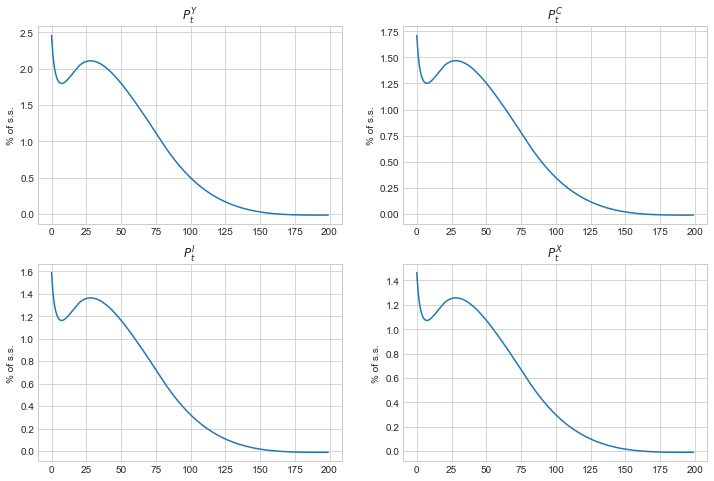

In [72]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2,2,1)
ax.plot((sol.P_Y[:T_IRF]/ss.P_Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^Y_t$')

ax = fig.add_subplot(2,2,2)
ax.plot((sol.P_C[:T_IRF]/ss.P_C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^C_t$')

ax = fig.add_subplot(2,2,3)
ax.plot((sol.P_I[:T_IRF]/(ss.P_I)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^I_t$')

ax = fig.add_subplot(2,2,4)
ax.plot((sol.P_X[:T_IRF]/(ss.P_X)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$P^X_t$');

# Comparison

In [73]:
model_copy = model.copy()
model_copy.par.Lambda = 0.15
model_copy.find_ss(0.50)
model_copy.calc_jac(do_print=True)

Labor supply and search and matching:
ss.S = 7.44,  ss.L = 56.28,  ss.delta_L = 0.07,  ss.v = 16.52,  ss.m_v = 0.23
Capital agency FOC:
ss.r_K = 0.14
Production firm pricing:
ss.r_ell = 2.71
Labor agency:
ss.ell = 55.87,  ss.w = 2.68
Government:
ss.B_G = 150.00,  ss.G = 50.00,  ss.tau = 0.37
Households:
solving for household behavior: result.converged = True
ss.C = 91.23,  ss.B = 249.03
Production firm FOCs:
ss.K = 557.43
Capital accumulation equation:
ss.I = 55.74
Output in production firm:
ss.Y = 229.56
Market clearing:
ss.C_Y = 63.86,  ss.G_Y = 35.00,  ss.I_Y = 36.23,  ss.X_Y = 94.47
[ ss.C_M = 27.37,  ss.G_M = 15.00,  ss.I_M = 19.51,  ss.X_M = 62.98 ] = ss.M = 124.86
ss.X = 157.45
Bargaining:
par.phi = 0.988
Jacobian calculated in 11.3 secs secs


In [74]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
model_copy.sol.chi[:Tshock] = model_copy.ss.chi + shock*persistence

In [75]:
model_copy.find_IRF()

initial:
   max. abs. error = 4.37e+01
    0.00e+00 in bargaining_cond
    4.37e+01 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    6.72e+00 in mkt_clearing

it = 0
 solve: t1-t0 = 0.1 secs
   max. abs. error = 4.37e+01
    4.09e-03 in bargaining_cond
    1.07e+00 in Bq_match
    2.33e-03 in FOC_capital_agency
    6.94e-02 in FOC_K_ell
    1.06e+00 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.2 secs
   max. abs. error = 1.07e+00
    1.58e-03 in bargaining_cond
    2.37e-01 in Bq_match
    9.66e-04 in FOC_capital_agency
    2.41e-02 in FOC_K_ell
    4.53e-01 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 4.53e-01
    9.21e-05 in bargaining_cond
    1.88e-02 in Bq_match
    4.06e-05 in FOC_capital_agency
    1.39e-03 in FOC_K_ell
    2.58e-02 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

Text(0.5, 1.0, 'Production, $Y_t$')

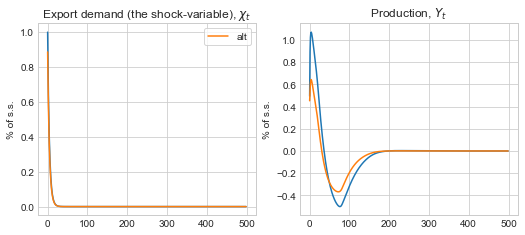

In [76]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.plot((model_copy.sol.chi[:T_IRF]/model_copy.ss.chi-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand (the shock-variable), $\chi_t$')
ax.legend(frameon=True)

ax = fig.add_subplot(3,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.plot((model_copy.sol.Y[:T_IRF]/model_copy.ss.Y-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')


Text(0.5, 1.0, 'wage, $w_t$')

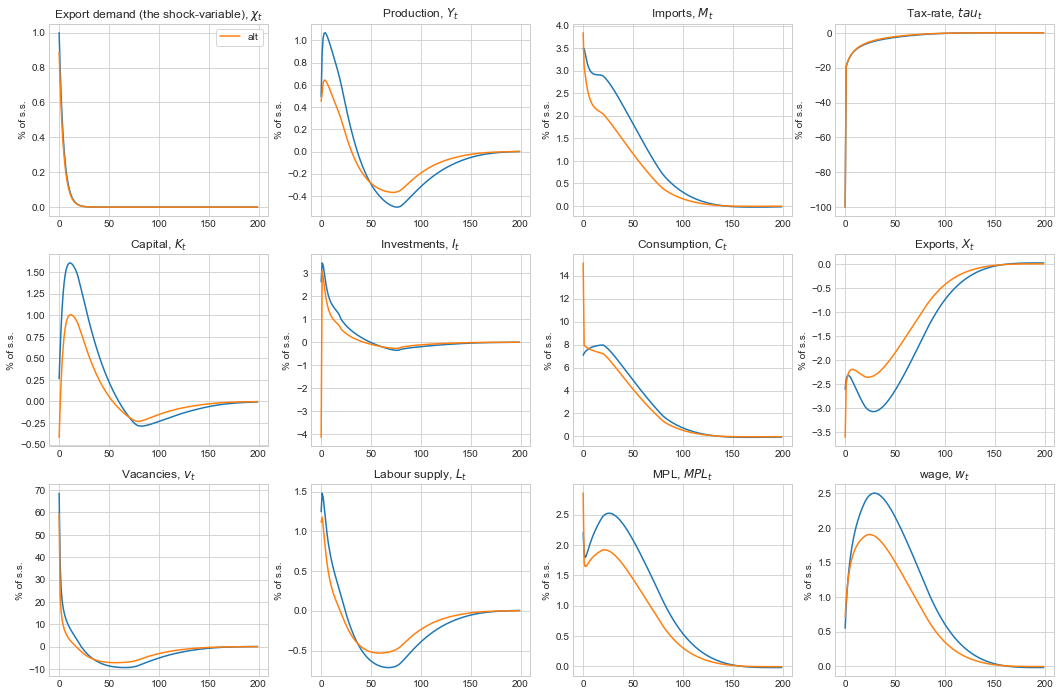

In [77]:
T_IRF = 200

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.plot((model_copy.sol.chi[:T_IRF]/model_copy.ss.chi-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand (the shock-variable), $\chi_t$')
ax.legend(frameon=True)

ax = fig.add_subplot(3,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.plot((model_copy.sol.Y[:T_IRF]/model_copy.ss.Y-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,4,3)
ax.plot((sol.M[:T_IRF]/ss.M-1)*100)
ax.plot((model_copy.sol.M[:T_IRF]/model_copy.ss.M-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Imports, $M_t$')

ax = fig.add_subplot(3,4,4)
ax.plot((sol.tau[:T_IRF]/ss.tau-1)*100)
ax.plot((model_copy.sol.tau[:T_IRF]/model_copy.ss.tau-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Tax-rate, $tau_t$')

ax = fig.add_subplot(3,4,5)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.plot((model_copy.sol.K[:T_IRF]/model_copy.ss.K-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,4,6)
ax.plot((sol.I[:T_IRF]/ss.I-1)*100)
ax.plot((model_copy.sol.I[:T_IRF]/model_copy.ss.I-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Investments, $I_t$')

ax = fig.add_subplot(3,4,7)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.plot((model_copy.sol.C[:T_IRF]/model_copy.ss.C-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,4,8)
ax.plot((sol.X[:T_IRF]/ss.X-1)*100)
ax.plot((model_copy.sol.X[:T_IRF]/model_copy.ss.X-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Exports, $X_t$')

ax = fig.add_subplot(3,4,9)
ax.plot((sol.v[:T_IRF]/ss.v-1)*100)
ax.plot((model_copy.sol.v[:T_IRF]/model_copy.ss.v-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Vacancies, $v_t$')

ax = fig.add_subplot(3,4,10)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.plot((model_copy.sol.L[:T_IRF]/model_copy.ss.L-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Labour supply, $L_t$')

ax = fig.add_subplot(3,4,11)
ax.plot((sol.MPL[:T_IRF]/ss.MPL-1)*100)
ax.plot((model_copy.sol.MPL[:T_IRF]/model_copy.ss.MPL-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('MPL, $MPL_t$')

ax = fig.add_subplot(3,4,12)
ax.plot((sol.w[:T_IRF]/ss.w-1)*100)
ax.plot((model_copy.sol.w[:T_IRF]/model_copy.ss.w-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('wage, $w_t$')

# Impulse-Response - Public Spending

In [78]:
model.set_exo_ss()

We shock G

In [79]:
Gshock = 50
shock = 0.01*ss.G
persistence = 0.8**np.arange(Gshock)
sol.G[:Gshock] = ss.G + shock*persistence

In [80]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 5.07e+01
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 3.50e-01


In [81]:
model.find_IRF()

initial:
   max. abs. error = 5.07e+01
    0.00e+00 in bargaining_cond
    5.07e+01 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    3.50e-01 in mkt_clearing

it = 0
 solve: t1-t0 = 0.1 secs
   max. abs. error = 5.07e+01
    2.13e-03 in bargaining_cond
    1.89e+00 in Bq_match
    5.07e-04 in FOC_capital_agency
    3.20e-02 in FOC_K_ell
    5.18e-01 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.1 secs
   max. abs. error = 1.89e+00
    6.87e-04 in bargaining_cond
    3.96e-01 in Bq_match
    7.94e-04 in FOC_capital_agency
    1.35e-02 in FOC_K_ell
    2.16e-01 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 3.96e-01
    3.31e-04 in bargaining_cond
    7.59e-02 in Bq_match
    1.58e-04 in FOC_capital_agency
    4.86e-03 in FOC_K_ell
    8.68e-02 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

Note: resultater


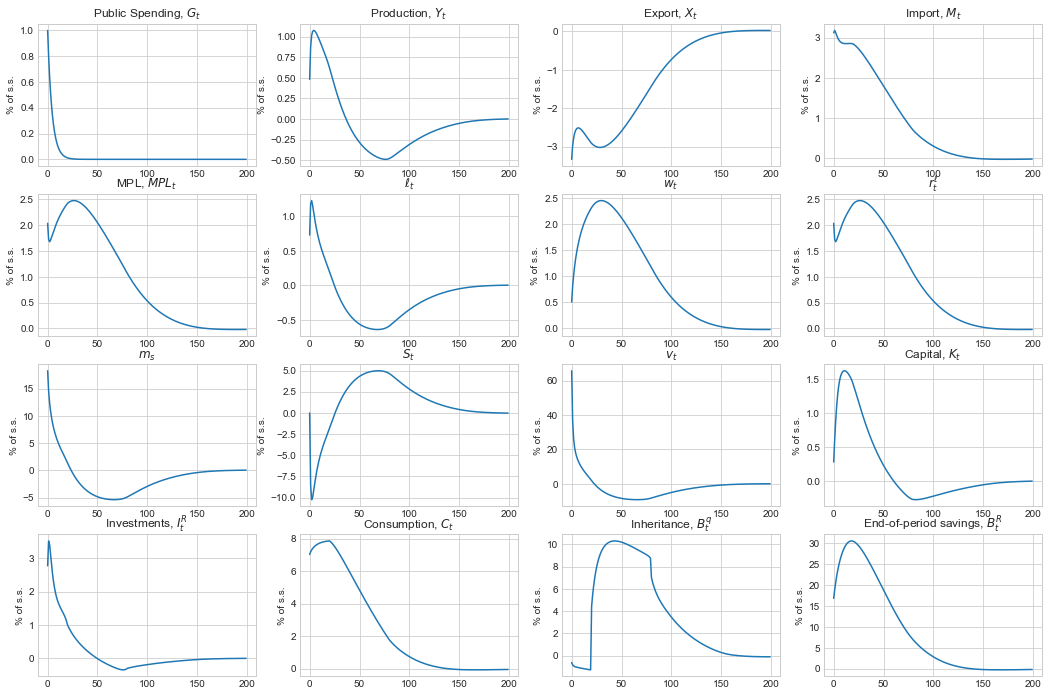

In [82]:
T_IRF = 200

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(4,4,1)
ax.plot((sol.G[:T_IRF]/ss.G-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Public Spending, $G_t$')

ax = fig.add_subplot(4,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(4,4,3)
ax.plot((sol.X[:T_IRF]/(ss.X)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export, $X_t$')

ax = fig.add_subplot(4,4,4)
ax.plot((sol.M[:T_IRF]/(ss.M)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import, $M_t$')

ax = fig.add_subplot(4,4,5)
ax.plot((sol.MPL[:T_IRF]/ss.MPL-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('MPL, $MPL_t$')

ax = fig.add_subplot(4,4,6)
ax.plot((sol.ell[:T_IRF]/(ss.ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$\ell_t$')

ax = fig.add_subplot(4,4,7)
ax.plot((sol.w[:T_IRF]/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$w_t$')

ax = fig.add_subplot(4,4,8)
ax.plot((sol.r_ell[:T_IRF]/(ss.r_ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$r^{\ell}_t$')

ax = fig.add_subplot(4,4,9)
ax.plot((sol.m_s[:T_IRF]/(ss.m_s)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$m_s$')

ax = fig.add_subplot(4,4,10)
ax.plot((sol.S[:T_IRF]/(ss.S)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$S_t$')

ax = fig.add_subplot(4,4,11)
ax.plot((sol.v[:T_IRF]/(ss.v)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$v_t$')

ax = fig.add_subplot(4,4,12)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(4,4,13)
ax.plot((sol.I[:T_IRF]/(ss.I)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Investments, $I^R_t$')

ax = fig.add_subplot(4,4,14)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(4,4,15)
ax.plot((sol.Bq[:T_IRF]/(ss.Bq)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Inheritance, $B^q_t$')

ax = fig.add_subplot(4,4,16)
ax.plot((sol.B[:T_IRF]/(ss.B)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('End-of-period savings, $B^R_t$');

print('Note: resultater')

Note: resultater priser mm.


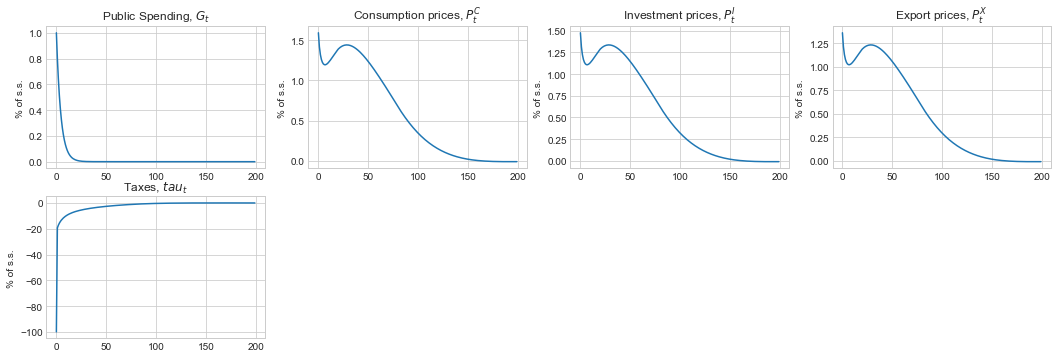

In [83]:
T_IRF = 200

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(4,4,1)
ax.plot((sol.G[:T_IRF]/ss.G-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Public Spending, $G_t$')

ax = fig.add_subplot(4,4,2)
ax.plot((sol.P_C[:T_IRF]/ss.P_C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption prices, $P^C_t$')

ax = fig.add_subplot(4,4,3)
ax.plot((sol.P_I[:T_IRF]/ss.P_I-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Investment prices, $P^I_t$')

ax = fig.add_subplot(4,4,4)
ax.plot((sol.P_X[:T_IRF]/ss.P_X-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export prices, $P^X_t$')

ax = fig.add_subplot(4,4,5)
ax.plot((sol.tau[:T_IRF]/ss.tau-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Taxes, $tau_t$')




print('Note: resultater priser mm.')